## Gensim Bigram topic modeling (adj +nouns)

In [1]:
import pickle
import pandas as pd  
import numpy as np 
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from nltk.corpus import stopwords

import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from wordcloud import STOPWORDS
STOPWORDS = set(STOPWORDS)

import re
import string   
import en_core_web_sm

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


## Data Preprcossing

In [3]:
nlp = en_core_web_sm.load()

In [4]:
df=pd.read_csv('before_election.csv')
df=df[['tweet_cleaned']]
df.dropna(subset=['tweet_cleaned'],axis=0, inplace=True)

In [5]:
tokenizer=Tokenizer(nlp.vocab)
custom_stopwords=['hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@','2020','election', 'vote', 'president', 'presidents', 'US', 'us', 'america', 'American', 'elections', 'campaign', 'unites state', 'unite state', 'usa','americans', 'white house', '#', 'usa', 'trump', 'biden', 'amp']
sw_nltk=stopwords.words('english')  #nltk stopwords
stop_words=nlp.Defaults.stop_words.union(custom_stopwords)  ##stop_words from Spacy
all_stop_words=stop_words.union(SW).union(STOPWORDS).union(sw_nltk)   # combine all stopwords from nltk, spacy, wordcloud 

In [16]:
## Use Spacy tokenization, remove all stop words from cleaned tweets
tokens = []
for doc in tokenizer.pipe(df['tweet_cleaned'], batch_size=500):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in all_stop_words:
            doc_tokens.append(token.text.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
df['tokens'] = tokens
df['tokens_text'] = [' '.join(map(str, l)) for l in df['tokens']]

In [27]:
data=df.tokens_text.values.tolist()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['elecciones', 'florida', 'dice', 'que', 'solo', 'preocupa', 'por', 'mismo', 'dem', 'crata', 'fue', 'anfitri', 'encuentros', 'electores', 'pembrokepines', 'miramar', 'clic', 'aqu', 'elsollatino']]


## Create the Bigram Models

In [28]:
# creating bigram and Trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [29]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
data_words_bigrams = make_bigrams(data_words)

In [30]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ']):  #select nouns and adjectives
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [31]:
data_lemmatized=lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ'])   ## running process is long

In [32]:
print(data_lemmatized[:1])

[['anfitri', 'encuentro']]


## Topic Modeling 

In [33]:
## create a id2word dictionary
id2word=Dictionary(data_lemmatized)
corpus=[id2word.doc2bow(d) for d in data_lemmatized]
print(corpus[:1])
print(len(id2word))

[[(0, 1), (1, 1)]]
41088


In [34]:
# Instantiate a LDA model using LDAmulticore
lda_model=LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=10)

In [37]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.046*"covid" + 0.020*"people" + 0.018*"care" + 0.018*"black" + '
  '0.016*"support" + 0.014*"pandemic" + 0.014*"year" + 0.010*"virus" + '
  '0.009*"old" + 0.009*"man"'),
 (1,
  '0.064*"debate" + 0.020*"tax" + 0.016*"plan" + 0.015*"money" + 0.013*"covid" '
  '+ 0.012*"tonight" + 0.010*"corruption" + 0.010*"presidential" + '
  '0.009*"economy" + 0.009*"point"'),
 (2,
  '0.035*"today" + 0.015*"right" + 0.013*"voting" + 0.012*"job" + '
  '0.011*"supporter" + 0.010*"year" + 0.009*"reason" + 0.008*"news" + '
  '0.007*"minute" + 0.007*"democracy"'),
 (3,
  '0.037*"people" + 0.024*"country" + 0.019*"landslide" + 0.017*"good" + '
  '0.014*"american" + 0.013*"day" + 0.012*"man" + 0.012*"love" + 0.010*"great" '
  '+ 0.009*"poll"'),
 (4,
  '0.022*"family" + 0.016*"bad" + 0.016*"time" + 0.015*"lie" + 0.013*"state" + '
  '0.012*"thing" + 0.009*"republican" + 0.008*"truth" + 0.008*"foxnew" + '
  '0.008*"well"')]


In [38]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics()]
topics = [' '.join(t[0:20]) for t in words]
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
covid people care black support pandemic year virus old man

------ Topic 1 ------
debate tax plan money covid tonight corruption presidential economy point

------ Topic 2 ------
today right voting job supporter year reason news minute democracy

------ Topic 3 ------
people country landslide good american day man love great poll

------ Topic 4 ------
family bad time lie state thing republican truth foxnew well



In [39]:
## measure the model performance
base_perplexity=lda_model.log_perplexity(corpus)
print('The LDA_model Perplexity is', base_perplexity)

The LDA_model Perplexity is -8.199135316699802


In [40]:
## compute the coherence score: very low coherence score
coherence_model=CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_model_base=coherence_model.get_coherence()
print('Coherence Score:', coherence_lda_model_base)

Coherence Score: 0.1462892257132667


In [41]:
## Visulaize the topic modeling using pyLDAvis
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model,corpus,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.158370  0.049013       1        1  22.010172
4     -0.050115  0.053434       2        1  20.614679
0     -0.052112 -0.244128       3        1  19.765500
1      0.252121 -0.014294       4        1  19.110746
2      0.008476  0.155974       5        1  18.498904, topic_info=          Term          Freq         Total Category  logprob  loglift
653     debate  11317.000000  11317.000000  Default  30.0000  30.0000
102      covid  10736.000000  10736.000000  Default  29.0000  29.0000
246      today   5943.000000   5943.000000  Default  28.0000  28.0000
981  landslide   3944.000000   3944.000000  Default  27.0000  27.0000
620        tax   3577.000000   3577.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
197        big    732.438751   3216.010373   Topic5  -5.4521   0.2079
194       time    842.531884   7044.574842   Topic5  -5.3121  -0.4361
325       fact    689.471832   2465.796282   Topic5  -5.5126   0.4131
312        day    703.547836   5437.372111   Topic5  -5.4924  -0.3575
26       thing    657.044414   3819.470723   Topic5  -5.5608  -0.0727

[393 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
62        1  0.001664  account
62        2  0.008321  account
62        4  0.169743  account
62        5  0.820427  account
1129      1  0.002255   action
...     ...       ...      ...
86        4  0.001771    young
86        5  0.005312    young
344       1  0.842361  youtube
344       2  0.009315  youtube
344       4  0.147713  youtube

[1023 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 2, 3])

In [42]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=12, passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

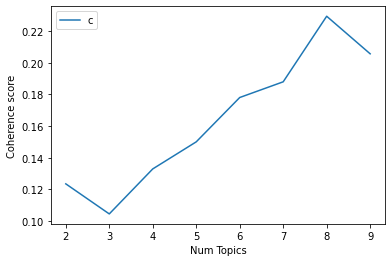

In [43]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [44]:
# select 7 model topics based on the curve 
lda_model=LdaMulticore(corpus=corpus, num_topics=8, id2word=id2word, workers=12, passes=10)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.037*"landslide" + 0.036*"year" + 0.035*"good" + 0.022*"man" + 0.015*"win" '
  '+ 0.015*"supporter" + 0.012*"job" + 0.011*"old" + 0.010*"big" + '
  '0.009*"time"'),
 (1,
  '0.116*"debate" + 0.018*"night" + 0.018*"country" + 0.018*"tonight" + '
  '0.015*"presidential" + 0.014*"thing" + 0.013*"good" + 0.012*"penny" + '
  '0.011*"final" + 0.010*"debatetonight"'),
 (2,
  '0.085*"people" + 0.022*"black" + 0.020*"family" + 0.020*"care" + '
  '0.013*"reason" + 0.013*"american" + 0.013*"man" + 0.012*"question" + '
  '0.011*"friend" + 0.010*"truth"'),
 (3,
  '0.041*"today" + 0.036*"day" + 0.023*"money" + 0.021*"news" + 0.019*"maga" + '
  '0.016*"woman" + 0.013*"foxnew" + 0.013*"support" + 0.012*"fake" + '
  '0.012*"right"'),
 (4,
  '0.038*"tax" + 0.023*"politic" + 0.020*"video" + 0.016*"point" + 0.015*"end" '
  '+ 0.013*"watch" + 0.012*"racist" + 0.011*"pay" + 0.010*"year" + '
  '0.009*"term"'),
 (5,
  '0.079*"covid" + 0.029*"plan" + 0.022*"death" + 0.022*"pandemic" + '
  '0.021*"votin

In [45]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model,corpus,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.111922 -0.135546       1        1  14.479962
2     -0.042249 -0.092484       2        1  14.051118
7     -0.009172 -0.062977       3        1  13.364650
0     -0.009887 -0.068432       4        1  12.838606
6      0.011766  0.248236       5        1  11.939293
3      0.038161  0.140111       6        1  11.847607
4      0.301580 -0.070340       7        1  10.885500
1     -0.178278  0.041432       8        1  10.593266, topic_info=          Term          Freq         Total Category  logprob  loglift
653     debate  11335.000000  11335.000000  Default  30.0000  30.0000
102      covid  10679.000000  10679.000000  Default  29.0000  29.0000
13      people  14273.000000  14273.000000  Default  28.0000  28.0000
246      today   4714.000000   4714.000000  Default  27.0000  27.0000
981  landslide   4344.000000   4344.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
29    question    472.782361   2103.116962   Topic8  -5.3324   0.7524
55      leader    461.399572   1977.741919   Topic8  -5.3567   0.7895
25       right    504.853207   3366.360005   Topic8  -5.2667   0.3476
13      people    508.981871  14273.669345   Topic8  -5.2586  -1.0888
738      black    387.459824   3278.881648   Topic8  -5.5314   0.1093

[576 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2381      2  0.102630        abortion
2381      6  0.895164        abortion
2446      8  0.990117             aca
3513      2  0.990496  accomplishment
3513      8  0.006003  accomplishment
...     ...       ...             ...
344       2  0.011275         youtube
344       5  0.243046         youtube
344       6  0.744171         youtube
344       7  0.001253         youtube
344       8  0.001253         youtube

[1792 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 8, 1, 7, 4, 5, 2])

### * In summary: Bigram using (adj+nouns) did not generate distinct topics compared with previsous tried LDA modeling (only using adj + nouns)